# <center> <font style="color:rgb(100,109,254)"> Facial Cloning   </font> </center>

Now with seamless cloning you can create some really interesting facial masks, you can put someone's face on top of the other and it'll look really interesting and weird. <br>
For this you would need to pass in a binary mask in which only the face region is white, now you could use `Dlib` library to automatically detect facial outline but since dlib will not be covered in this course, we will manually pass in a mask which you can easily create in photoshop or write a simple python opencv script which lets user create a mask by drawing it with the mouse.

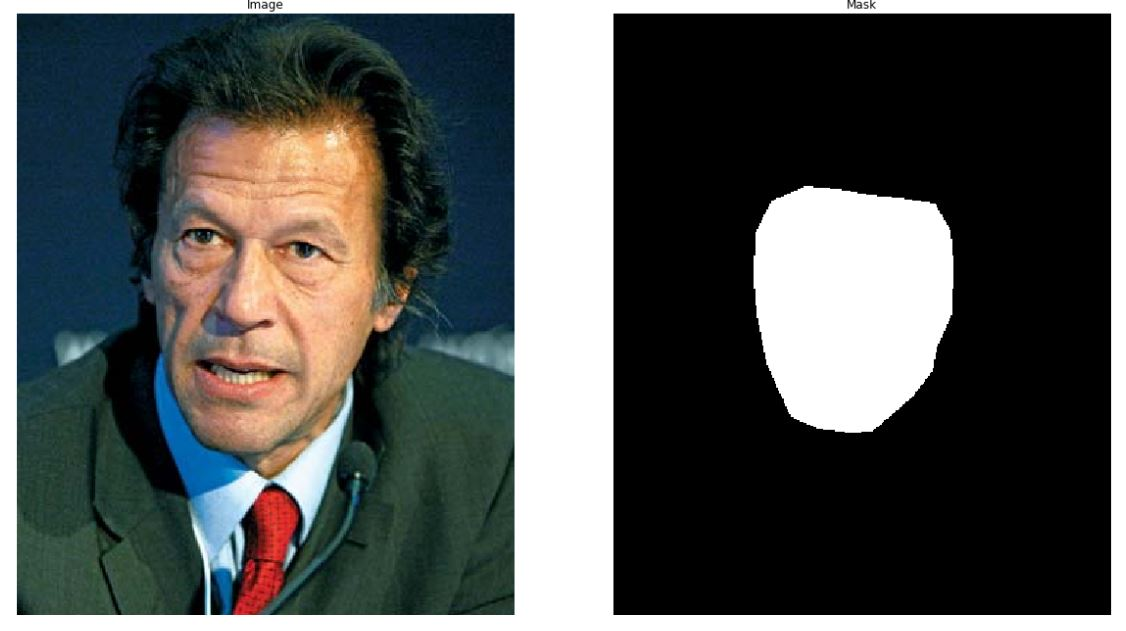

Or you can also try doing face detection and from the face, extract an oval hull, most faces roi will be approximated this way but its not a perfect way.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### <font style="color:rgb(134,19,348)"> Function to Extract Mask </font>
Below function lets the user specify some points and then using these points we can get a binary mask of the image.

In [ ]:
def givep(img):
    if img is None:
        print('Img is None, make sure the path and name is correct')
        return []
    
    # a list that will store all points that a user clicks on the image
    allpoints = []
    
    # whenever user clicks with left button.
    def draw_circle(event,x,y,flags,param):
        global points, x1,x2,y1,y2,cropped

        if event == cv2.EVENT_LBUTTONDBLCLK:
            allpoints.append((x,y))
            cv2.circle(img,(x,y),5,(255,0,0),-1)

    cv2.namedWindow('image')
    cv2.setMouseCallback('image',draw_circle)
    
    while(1):
        # break the loop and return all stored points when the user presses the ESC button
        cv2.imshow('image',img)
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
    cv2.destroyAllWindows()
    
    return allpoints

**Now that we have created the above function lets use it to get the points and draw the required mask**

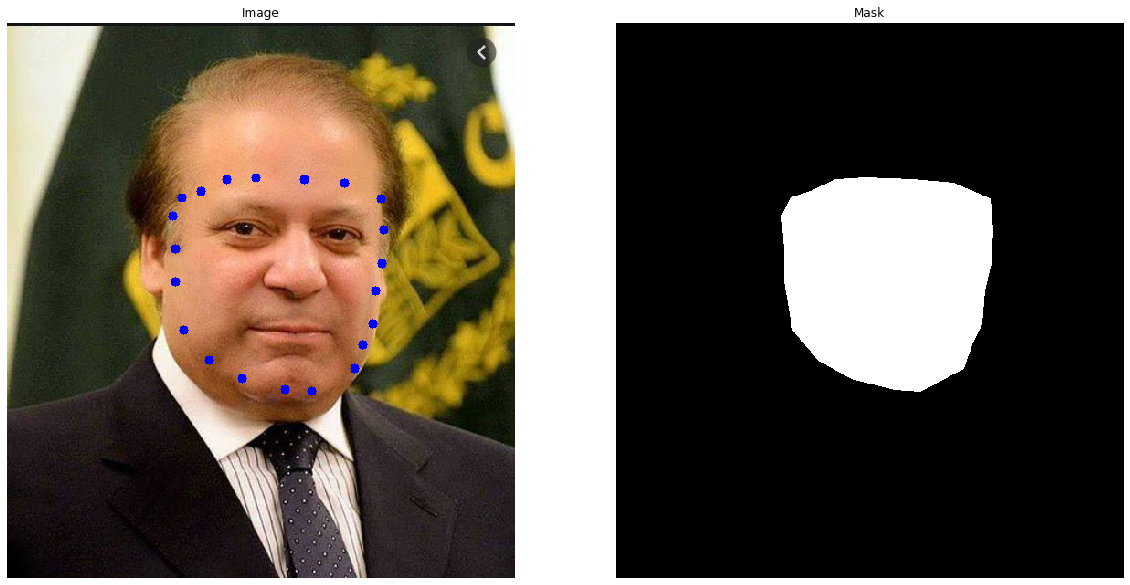

In [20]:
# set the base path properly (location where image is present)
base_path = 'media/M4/'

# set the name of the image
img_name = 'sharif.jpg'

# read the image
image = cv2.imread(base_path+img_name,1)

# get all the points
allpoints = givep(image)

# create a black image of the same size as original image
mask = np.zeros(image.shape, dtype='uint8')

# draw a polygon using all the points the user selected
mask = cv2.fillPoly(mask, [np.array(allpoints)], (255, 255, 255))

# Save the mask by the same name of image but append the 'mask' at then end
cv2.imwrite(base_path + img_name.split('.')[0] + 'mask' + '.jpg', mask)

# show the mask
plt.figure(figsize=[20,20])
plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Image");plt.axis('off')
plt.subplot(122);plt.imshow(mask, cmap='gray');plt.title("Mask");plt.axis('off');

**We will be resizing both images to be same so they both have faces in the same place**

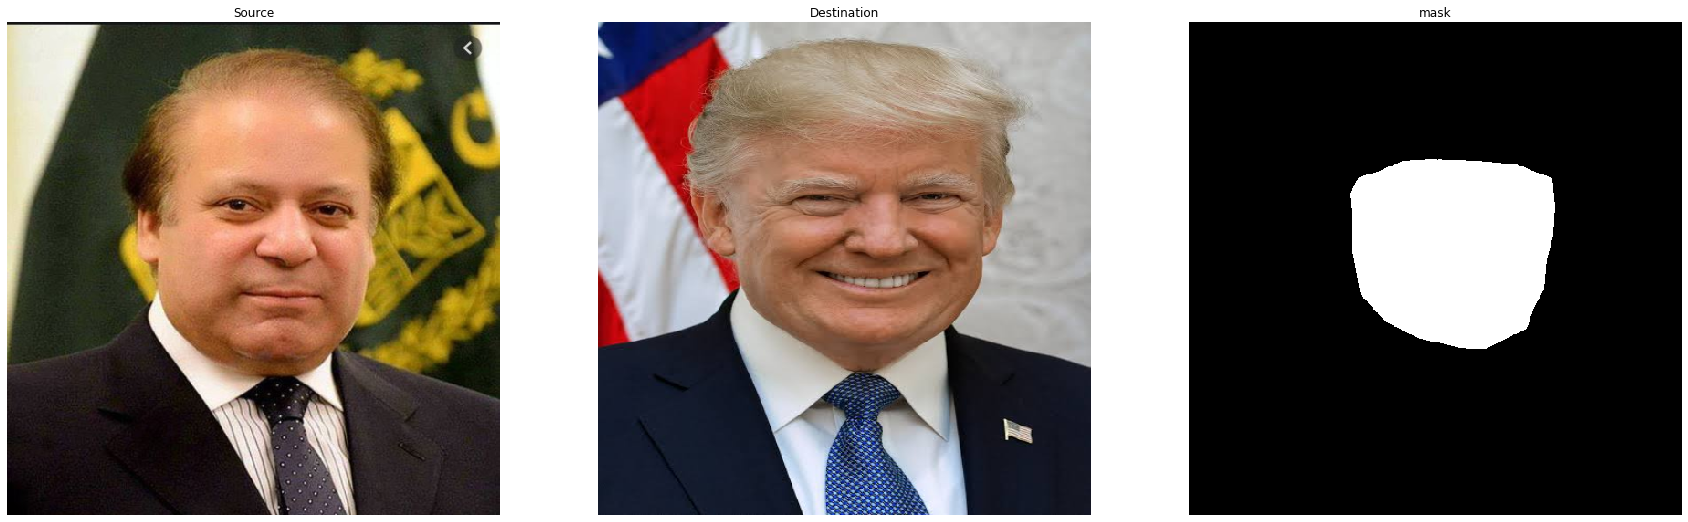

In [21]:
%matplotlib inline

base_path = 'media/M4/'

destination_img_name = 'trump.jpg'
img_name = 'sharif.jpg'

destination = cv2.imread(base_path + destination_img_name ,1)
source = cv2.imread(base_path+img_name,1)

size = (540,540)

# resize them to the same size (not required but for this example this makes our work easier)
destination = cv2.resize(destination, size)
source = cv2.resize(source, size)

mask = cv2.imread(base_path + img_name.split('.')[0] + 'mask' + '.jpg',0 )
mask = cv2.resize(mask, size)

#this is to make sure we have no gray pixels (in outlines) all are either 0 or 255
ret, mask = cv2.threshold(mask, 240, 255, cv2.THRESH_BINARY)

plt.figure(figsize=[30,30])
plt.subplot(131);plt.imshow(source[:,:,::-1]);plt.title("Source");plt.axis('off')
plt.subplot(132);plt.imshow(destination[:,:,::-1]);plt.title("Destination");plt.axis('off');
plt.subplot(133);plt.imshow(mask, cmap = 'gray');plt.title('mask');plt.axis('off');

**Now just before we try to use seamless cloning, lets try to just paste the face using the mask and see the results.** 

Text(0.5, 1.0, 'Manual Overlay')

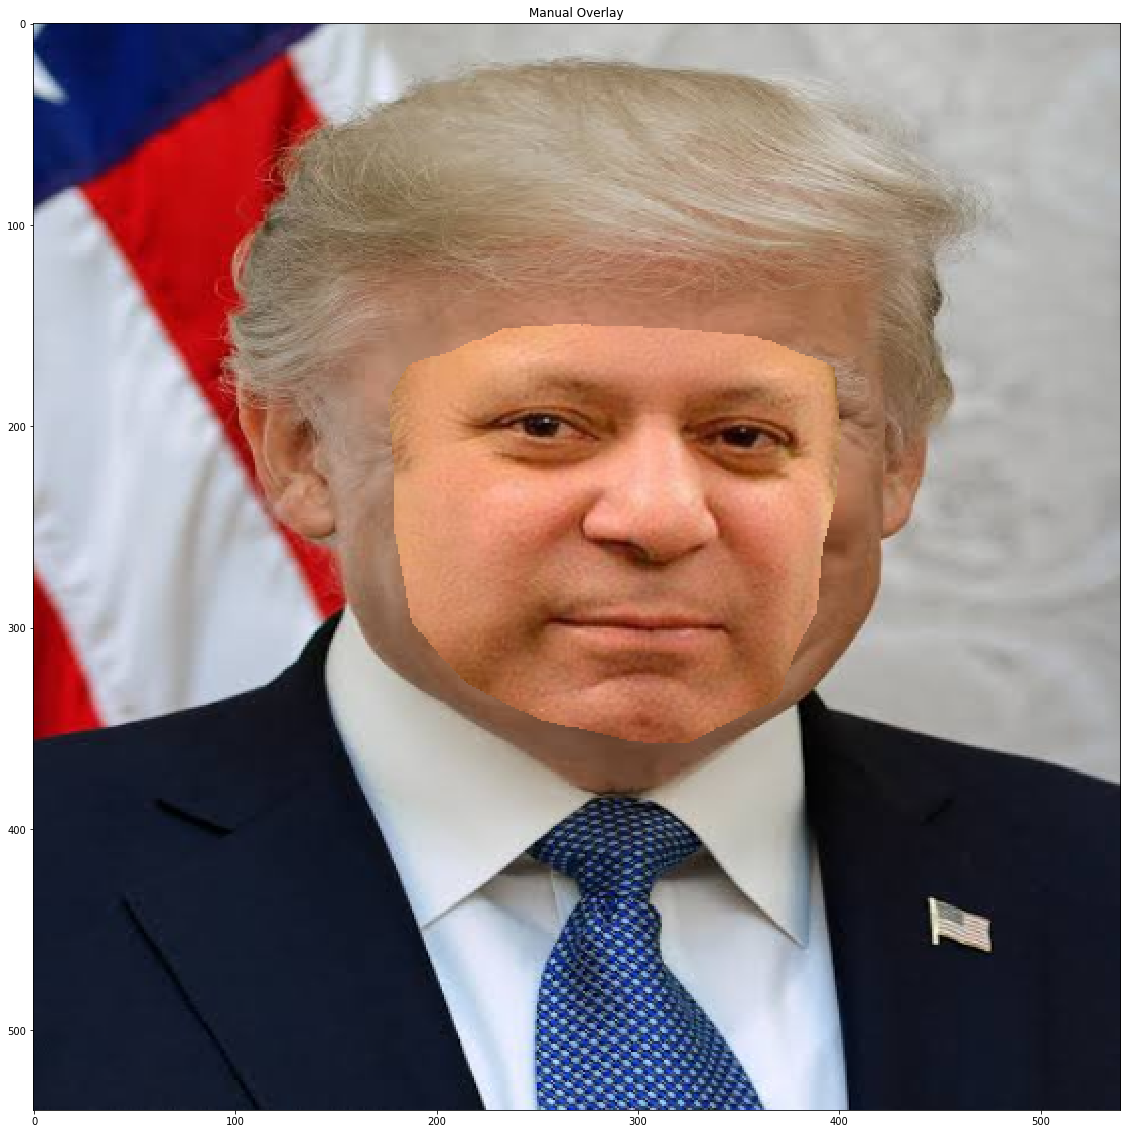

In [22]:
foreground = cv2.bitwise_and(source,source, mask = mask)
background = cv2.bitwise_and(destination,destination, mask = cv2.bitwise_not(mask))

combined = cv2.add(foreground ,background)

plt.figure(figsize=[20,20])
plt.imshow(combined[:,:,::-1]);plt.title("Manual Overlay")

**Now that we have a mask we can do blending, first lets try direct blending and then try seamless cloning**

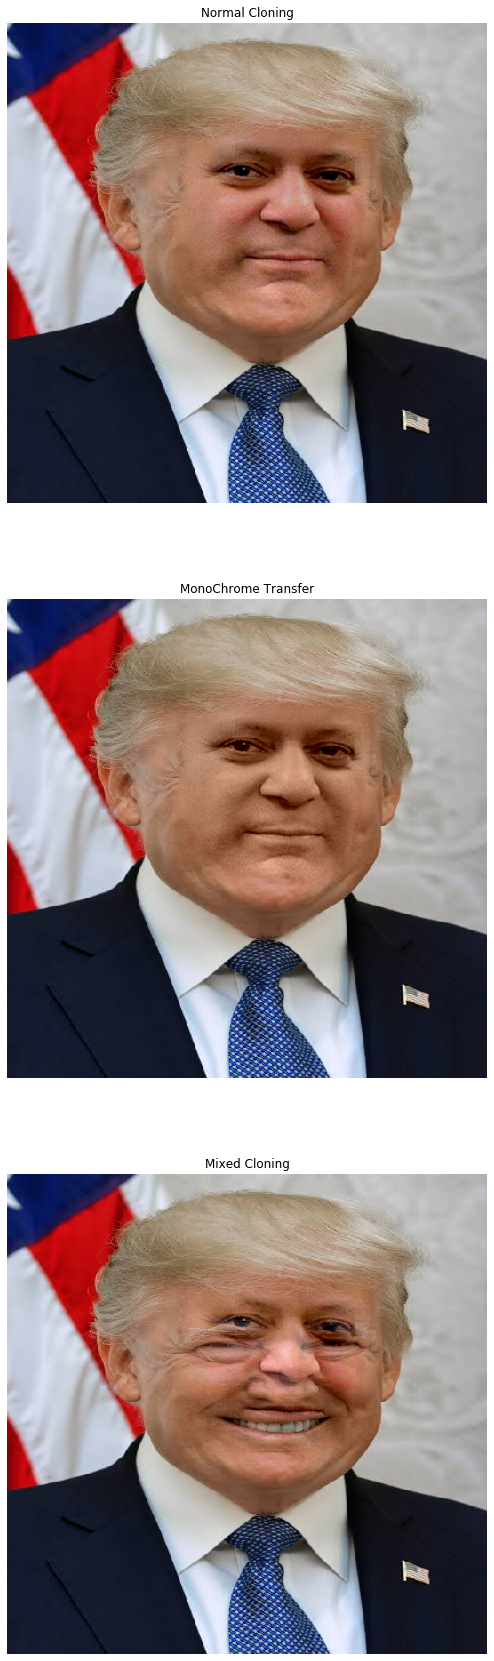

In [23]:
# center points now are half of the widh,height image + some constant values, which you can tune throught trial and error
height_constant = -50
width_constant = 30
center_point = (size[0]//2 + width_constant ,size[1]//2  + height_constant)

cloned_image_normal = cv2.seamlessClone(source, destination, mask, center_point, cv2.NORMAL_CLONE)
cloned_image_mixed = cv2.seamlessClone(source, destination, mask, center_point, cv2.MIXED_CLONE)
Monochrome = cv2.seamlessClone(source, destination, mask, center_point, cv2.MONOCHROME_TRANSFER)

%matplotlib inline
plt.figure(figsize=[30,30])
plt.subplot(311);plt.imshow(cloned_image_normal[:,:,::-1]);plt.title("Normal Cloning");plt.axis('off')
plt.subplot(312);plt.imshow(Monochrome[:,:,::-1]);plt.title("MonoChrome Transfer");plt.axis('off');
plt.subplot(313);plt.imshow(cloned_image_mixed[:,:,::-1]);plt.title("Mixed Cloning");plt.axis('off');

**It should not come as a surprise that the mix cloning sucks in this one, because in faces the features like eyes,nose mouth have high gradients and it tries to incorporate both of these gradients in the final result**

# <font style="color:rgb(134,19,348)"> A Better Approach </font>
The above results looks cool but the approach sucks, you have to first find images in which the faces lie approximately in the same place then you also have to manually adjust the faces in the end.<br>

We can improve our approach by incorporating face detection. First lets save a mask of just the face and also save the extracted face image.

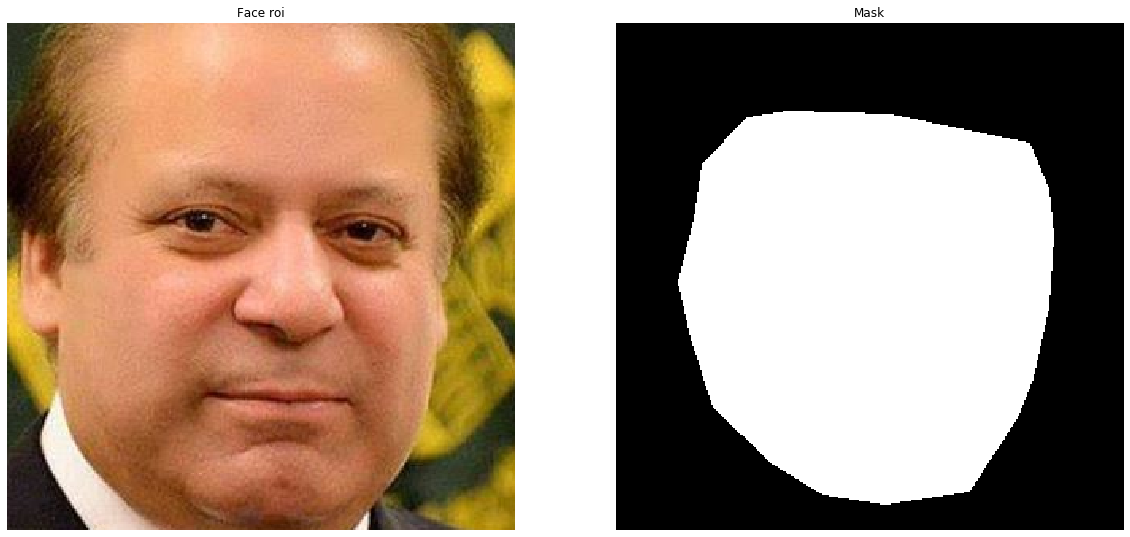

In [24]:
# set the base path properly (location where image is present)
base_path = 'media/M4/'

# set the name of the image
img_name = 'sharif.jpg'

# read the image
image = cv2.imread(base_path+img_name,1)

face_cascade = cv2.CascadeClassifier('media/M4/haarcascade_frontalface_default.xml')  

# perform the face detection and extract the first face
faces = face_cascade.detectMultiScale(image, 1.3, 5)
if len(faces) > 0:
 x,y,w,h=faces[0]
 faceroi = image[y:y+h, x:x+w]
    
# if face detection fails then maually crop out the image
else:
    r = cv2.selectROI(image)     
    faceroi =  image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]

# get all the points
allpoints = givep(faceroi.copy())

# create a black image of the same size as original image
mask = np.zeros(faceroi.shape, dtype='uint8')

# draw a polygon using all the points the user selected
mask = cv2.fillPoly(mask, [np.array(allpoints)], (255, 255, 255))

# Save the mask by the same name of image but append the 'mask' at then end
cv2.imwrite(base_path + img_name.split('.')[0] + 'mask' + '.jpg', mask)

# Also save the roi of face
cv2.imwrite(base_path + img_name.split('.')[0] + 'roi' + '.jpg', faceroi)

# show the mask
plt.figure(figsize=[20,20])
plt.subplot(121);plt.imshow(faceroi[:,:,::-1]);plt.title("Face roi");plt.axis('off')
plt.subplot(122);plt.imshow(mask, cmap='gray');plt.title("Mask");plt.axis('off');

## <font style="color:rgb(134,19,348)">Final Function  </font>
Here we are creating a function which can do the face cloning if two images are give, the source image can be either an image of the face in which case a mask will also be provided, or the image containing the face in which a generic mask will be used, now the below code is constructed such that if you're using it a video then you can set manual to False in which case the function will not interrupt the program for missed detection and the face can be detected on the next frame.

In [25]:
def cloner(source,destination,mask=None,manual=True,vis = True,full_image=False):
    
    origninalsource = source.copy()
    # This piece of code handles the condition in which we als0 want the face image to be extracted
    if full_image:
        faces = face_cascade.detectMultiScale(source, 1.3, 5)        

        if len(faces) > 0:
             x,y,w,h=faces[0]
             source = source[y:y+h, x:x+w]

        # if face detection fails then maually crop out the image
        else:
            if manual:                
                r = cv2.selectROI(source)     
                source =  source[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
            else:
               return None
        
    # Load a generic mask that approximate an average face if no mask was provided
    if mask is None:
        mask = cv2.imread('media/M4/commonmask.jpg',0 )

    # perform the face detection and extract the first face
    faces = face_cascade.detectMultiScale(destination, 1.3, 5)

    if len(faces) > 0:
     x,y,w,h=faces[0]
     faceroi = destination[y:y+h, x:x+w]
     # get the center of the face
     center_point = (x+w//2,y+h//2)

    # if face detection fails then maually crop out the image
    else:
        
        if manual: 
            r = cv2.selectROI(destination)   
            # get the width and height
            h = r[3]
            w = r[2]
            center_point = (x+w//2,y+h//2)
        else:
            return None

    # resize the source face and the mask according to the detected face
    size = (w,h)
    mask = cv2.resize(mask, size)
    source = cv2.resize(source, size)


    cloned_image_normal = cv2.seamlessClone(source, destination, mask, center_point, cv2.NORMAL_CLONE)
    Monochrome = cv2.seamlessClone(source, destination, mask, center_point, cv2.MONOCHROME_TRANSFER)

    if vis:
        plt.figure(figsize=[20,30])
        plt.subplot(221);plt.imshow(origninalsource[:,:,::-1]);plt.title("Source");plt.axis('off')
        plt.subplot(222);plt.imshow(destination[:,:,::-1]);plt.title("destination");plt.axis('off');
        plt.subplot(223);plt.imshow(cloned_image_normal[:,:,::-1]);plt.title("Normal Cloning");plt.axis('off')
        plt.subplot(224);plt.imshow(Monochrome[:,:,::-1]);plt.title("MonoChrome Transfer");plt.axis('off');

    return cloned_image_normal

**Now lets test our Function**

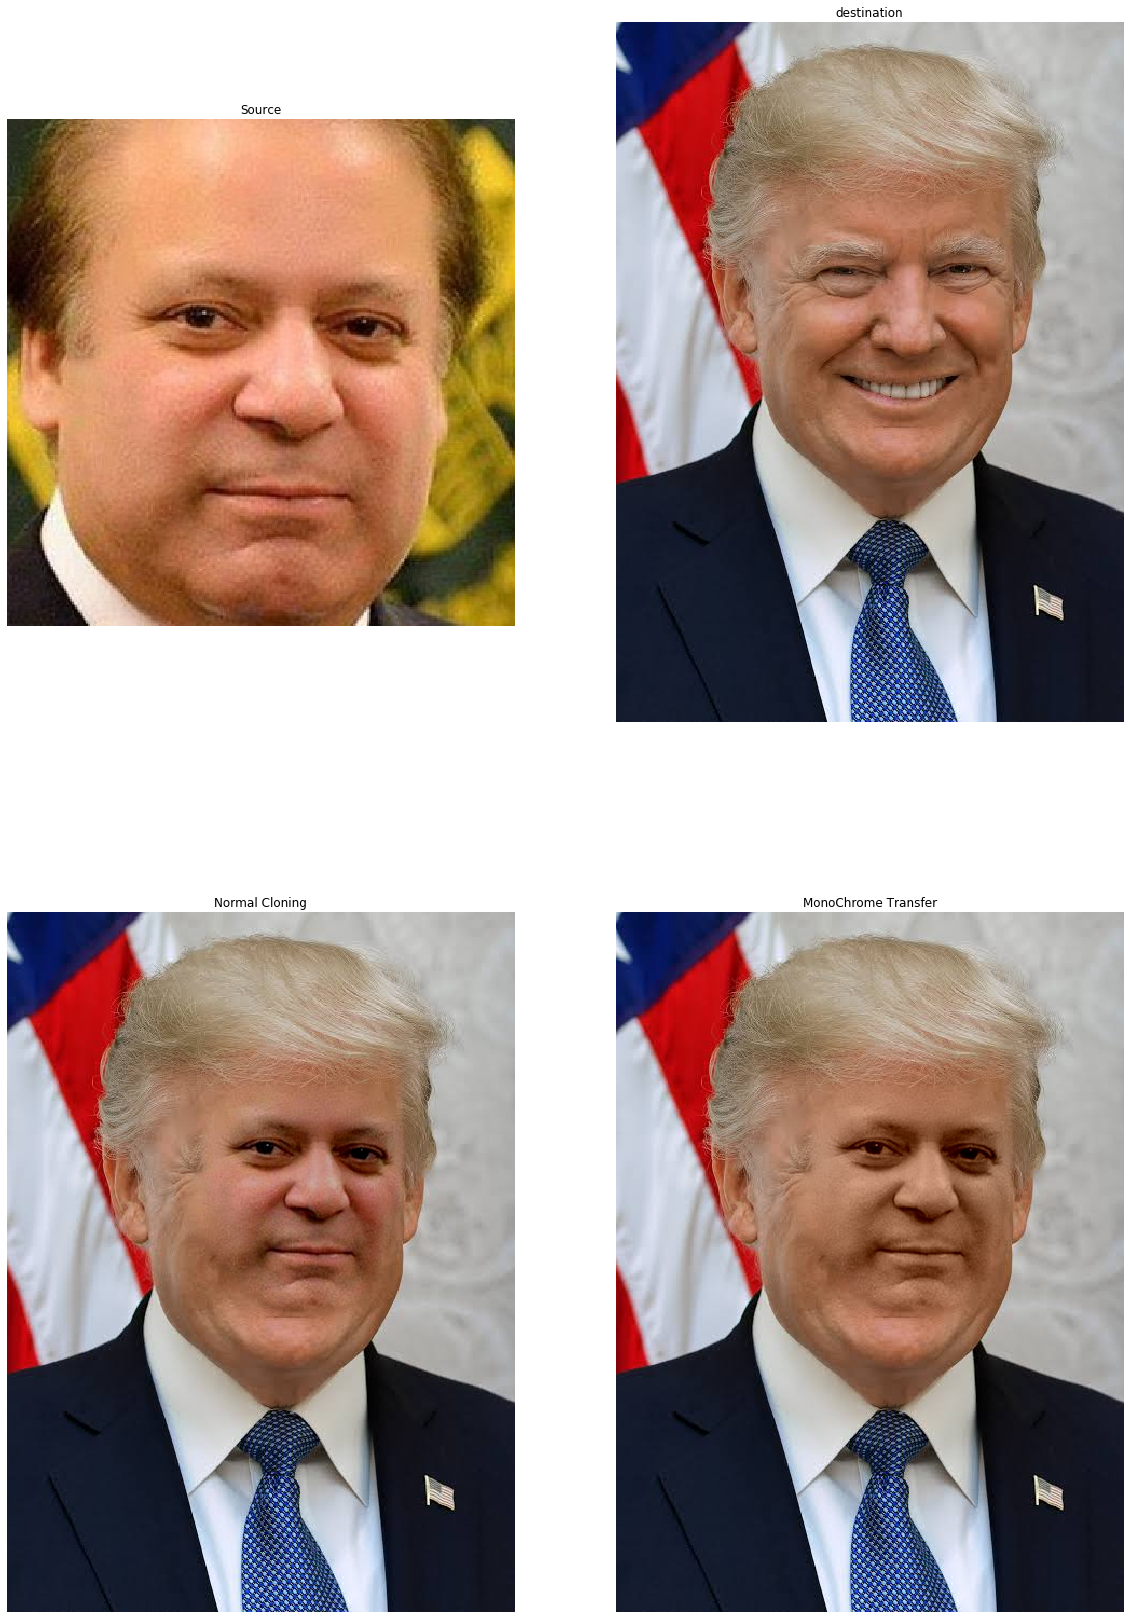

In [26]:
destination = cv2.imread('media/M4/trump.jpg' ,1)
source = cv2.imread('media/M4/sharifroi.jpg',1)
mask = cv2.imread('media/M4/sharifmask.jpg',0 )

cloned = cloner(source,destination,mask)

**Our Method is constructed such that it allows you to pass in full source images too**

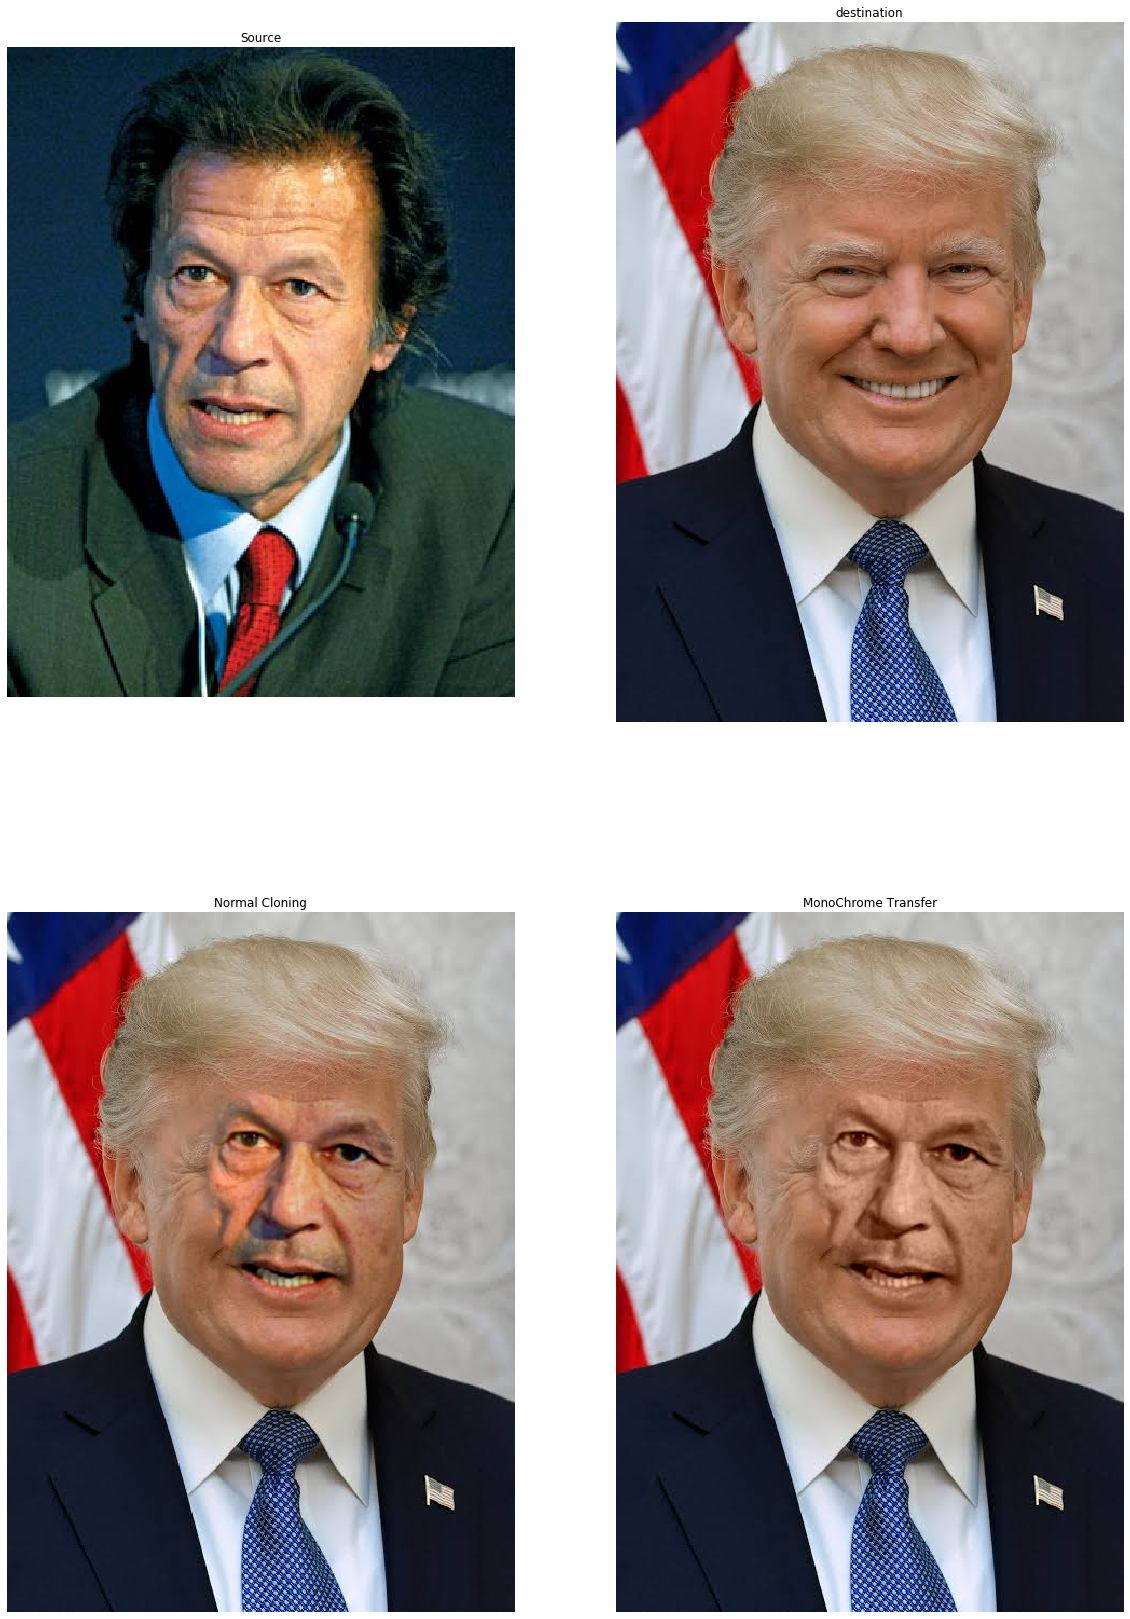

In [27]:
destination = cv2.imread('media/M4/trump.jpg' ,1)
source = cv2.imread('media/M4/imrankhanface1.jpg',1)

cloned = cloner(source,destination,full_image=True)

## <font style="color:rgb(134,19,348)"> Real time face Cloning </font>
Now lets try this on a real time webcam feed, we can easily use the same function to achieve this.<br>
**Note:** This approach is not suited for videos.

In [28]:
cap = cv2.VideoCapture(0)  

source = cv2.imread('media/M4/undertaker.jpg',1)

while (True):
    
  ret ,frame = cap.read()  
  if not ret:
        break
        
  frame = cv2.flip( frame, 1 )    
  cloned = cloner(source,frame,full_image=True,manual=False,vis=False)

  if cloned is None:
        cv2.imshow("img",frame)
  else:
    cv2.imshow("img",cloned)  
    
  k = cv2.waitKey(1)  & 0xFF

  if k == ord('q'):  
      break

  if k ==ord('s'):
      cv2.imwrite('media/M4/mysavedpicc.jpg',cloned)
      cv2.imshow('Picture Saved',cloned)  
                     
cap.release()
cv2.destroyAllWindows()  